In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Algorithm for Blade Element Theory

In [3]:
#function definition for BET with parameters as listed below
def BET(theta, a, sigma, omega, V=0): 
    v=0 
    
    #recursive loop to find C_T and v
    for _ in range(100):
        Ct=a*sigma/4* (4*theta/3 - (V+v)/omega/R)
        v=np.sqrt(Ct/2)*omega*R
    
    Lambda=(V+v)/omega/R
    
    Cd=0.0113+1.25* (theta-np.arctan(Lambda))

    Cq=(Lambda*Ct+sigma*Cd/8)/2
    return [Ct, Cq]
#returns Coeff of thrust, coeff of torque

## Algorithm for Blade Element Momentum Theory

In [4]:
#function definition for BEMT with parameters as listed below


def BEMT(no_of_blades, a, V, R, cutout, omega, c_hub, taper_ratio, theta_tip, twist, rho=1.12, Cdmin=0.0113, Cdc=1.25):
    
    Lambdac=V/omega/(R+cutout)

    def dTdQ( r, c, theta):

        sigma=c*no_of_blades/(r+cutout)/np.pi
        Lambda= np.sqrt( (sigma*a/16 - Lambdac/2)**2 + sigma*a*theta*(r+cutout)/8/(R+cutout) ) - (sigma*a/16 - Lambdac/2)
        
        #recursive loop for finding Prandtl tip loss function parameters
        for _ in range(5):
            f=no_of_blades/2/Lambda*(1-r/R)
            F=2/np.pi*np.arccos(np.exp(-f))
            if F>0.00001:
                Lambda= np.sqrt( (sigma*a/16/F - Lambdac/2)**2 + sigma*a*theta*(r+cutout)/8/(R+cutout)/F ) - (sigma*a/16 - Lambdac/2)
            
        Cl= a*(theta - Lambda)
        Cd= Cdmin+Cdc*(theta - np.arctan(Lambda))
        dQ=no_of_blades*c/2*rho *omega**2*r**3 *Cd
        dT=a*no_of_blades*c/2*rho* (omega*(r+cutout))**2 * (theta - Lambda) *F
        
        return dT, dQ

    r=np.linspace(0, R, 100)
    c=np.linspace(c_hub, c_hub/taper_ratio, 100)
    
    if twist==1:
        theta=[theta_tip*(R+cutout)/(g+cutout) for g in r]
    
    elif twist==0:
        theta=[theta_tip]*100
        
#torque and thrust are found by integrating dT and dQ as done below
    T= np.sum([ dTdQ( r[i], c[i], theta[i])[0]*R/100 for i in range(100) ])
    Q= np.sum([ dTdQ( r[i], c[i], theta[i])[1]*R/100 for i in range(100) ])
    
    Ct=T/rho/np.pi/(R+cutout)**4
    Cq=Q/rho/np.pi/(R+cutout)**5
    
#Ct and Cq are multiplied by 2 below to match the formula given in literature

    return [Ct*2, Cq*2, theta[0]-theta[-1], theta[75]] 

#returns Coeff of thrust, coeff of torque, twist angle and theta at 0.75R


# Benchmarking and Plotting

In [5]:
bet=[]
bemt=[]

a=5.75
sigma=0.0636
R=0.762
omega=10

for i in range(0,13, 2):
    try:
        bet.append([i, BET(i*np.pi/180, a, sigma, omega)[0], BET(i*np.pi/180, a, sigma, omega)[1]])
    except:
        bet.append([i, None ,None])
    try:
        
        bemt.append([i, BEMT(no_of_blades=3, a=5.75, V=0, R=0.762-0.125, cutout=0.125, omega=1, c_hub=0.0508, taper_ratio=1, theta_tip=i*np.pi/180, twist=0)[0], BEMT(no_of_blades=3, a=5.75, V=0, R=0.762-0.125, cutout=0.125, omega=1, c_hub=0.0508, taper_ratio=1, theta_tip=i*np.pi/180, twist=0)[1]])
    except:
        
        bemt.append([i, None ,None])
        
        
bet=np.array(bet)
bet=np.transpose(bet)

bemt=np.array(bemt)
bemt=np.transpose(bemt)
        
#ignore error

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17212\2950227708.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  f=no_of_blades/2/Lambda*(1-r/R)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17212\2950227708.py:15: RuntimeWarning: invalid value encountered in double_scalars
  f=no_of_blades/2/Lambda*(1-r/R)


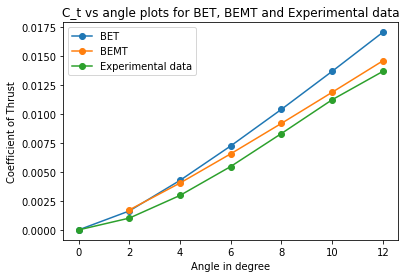

In [6]:
#plotting for Ct vs angle

plt.plot(bet[0], bet[1], 'o-')
plt.plot(bemt[0], bemt[1], 'o-')

expdata=[[0, 2, 4, 6, 8, 10, 12],[0, 0.00102, 0.00298, 0.00548, 0.00833, 0.01125, 0.01370]]
plt.plot(expdata[0], expdata[1], 'o-')

plt.xlabel("Angle in degree")
plt.ylabel("Coefficient of Thrust")

plt.legend(["BET", "BEMT", "Experimental data"])
plt.title("C_t vs angle plots for BET, BEMT and Experimental data");

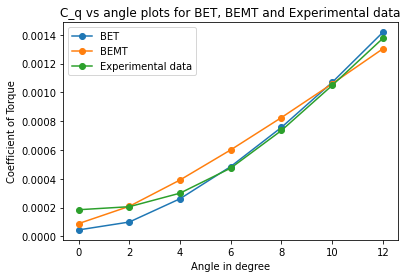

In [7]:
#plotting for Cq vs angle

plt.plot(bet[0], bet[2], 'o-')
plt.plot(bemt[0], bemt[2], 'o-')

expdata=[[0, 2, 4, 6, 8, 10, 12],[0.000185, 0.000206, 0.000300, 0.000474, 0.000735, 0.001048, 0.001375]]
plt.plot(expdata[0], expdata[1], 'o-')

plt.xlabel("Angle in degree")
plt.ylabel("Coefficient of Torque")
plt.legend(["BET", "BEMT", "Experimental data"])
plt.title("C_q vs angle plots for BET, BEMT and Experimental data");

# Design Variable Variations

### Analysis for Solidity

In [8]:
#Code for plotting Ct and Cp against Solidity

bemt=[]
for i in range(13):

    try: 
        
        bemt.append([i, BEMT(no_of_blades=3, a=5.75, V=0, R=0.762-0.125, cutout=0.125, omega=1, c_hub=i/2*0.0508, taper_ratio=1, theta_tip=10*np.pi/180, twist=0)[0], BEMT(no_of_blades=3, a=5.75, V=0, R=0.762-0.125, cutout=0.125, omega=1, c_hub=i/2*0.0508, taper_ratio=1, theta_tip=10*np.pi/180, twist=0)[1]])
    except:
        
        bemt.append([i, None ,None])
        
bemt2=np.array(bemt)
bemt2=np.transpose(bemt)
        
#ignore error

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17212\2950227708.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  f=no_of_blades/2/Lambda*(1-r/R)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17212\2950227708.py:15: RuntimeWarning: invalid value encountered in double_scalars
  f=no_of_blades/2/Lambda*(1-r/R)


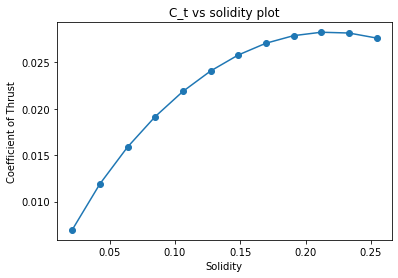

In [9]:
plt.plot(bemt2[0]*0.0424/2, bemt2[1], 'o-')


plt.xlabel("Solidity")
plt.ylabel("Coefficient of Thrust")
plt.title("C_t vs solidity plot");

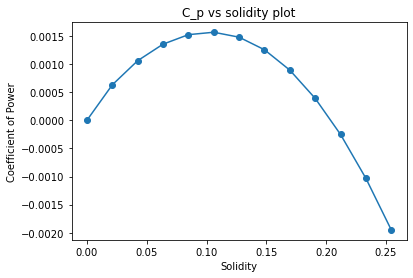

In [10]:
plt.plot(bemt2[0]*0.0424/2, bemt2[2], 'o-')


plt.xlabel("Solidity")
plt.ylabel("Coefficient of Power")
plt.title("C_p vs solidity plot");

### Analysis for Taper ratio

In [11]:
#Code for plotting Ct and Cp against taper ratio

bemt=[]

for i in range(13):
    
    try:
        
        bemt.append([i, BEMT(no_of_blades=3, a=5.75, V=0, R=0.762-0.125, cutout=0.125, omega=1, c_hub=0.508, taper_ratio=(i+2), theta_tip=10*np.pi/180, twist=0)[0], BEMT(no_of_blades=3, a=5.75, V=0, R=0.762-0.125, cutout=0.125, omega=1, c_hub=0.0508, taper_ratio=(i+2)/2, theta_tip=10*np.pi/180, twist=0)[1]])
    except:
        
        bemt.append([i, None ,None])
        
        
bemt3=np.array(bemt)
bemt3=np.transpose(bemt)

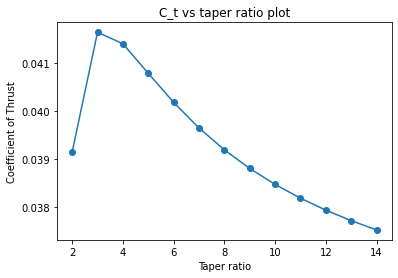

In [12]:
plt.plot((bemt3[0]+2), bemt3[1], 'o-')


plt.xlabel("Taper ratio")
plt.ylabel("Coefficient of Thrust")
plt.title("C_t vs taper ratio plot");

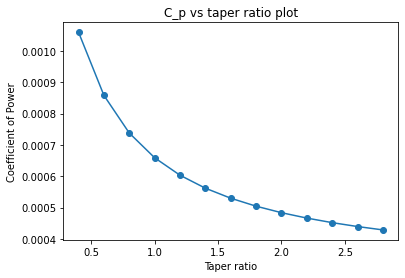

In [13]:
plt.plot((bemt3[0]+2)/5, bemt3[2], 'o-')


plt.xlabel("Taper ratio")
plt.ylabel("Coefficient of Power")
plt.title("C_p vs taper ratio plot");

### Analysis for Twist

In [14]:
#Code for plotting Ct and Cp against Twist

bemt=[]

for i in range(13):
    
    try:
        
        bemt.append([BEMT(no_of_blades=3, a=5.75, V=0, R=0.762-0.125, cutout=0.125, omega=1, c_hub=0.508, taper_ratio=1, theta_tip=(i+2)/2*np.pi/180, twist=1)[2], BEMT(no_of_blades=3, a=5.75, V=0, R=0.762-0.125, cutout=0.125, omega=1, c_hub=0.0508, taper_ratio=1, theta_tip=(i+2)*np.pi/180, twist=1)[0], BEMT(no_of_blades=3, a=5.75, V=0, R=0.762-0.125, cutout=0.125, omega=1, c_hub=0.0508, taper_ratio=1, theta_tip=(i+2)*np.pi/180, twist=1)[1]])
    except:
        
        bemt.append([None, None ,None])
        
        
bemt4=np.array(bemt)
bemt4=np.transpose(bemt)

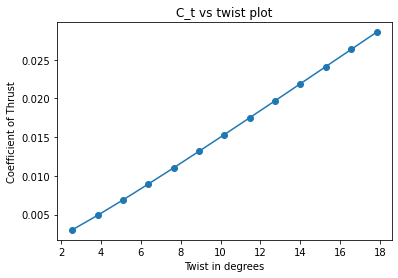

In [15]:
plt.plot((bemt4[0]/2*180/np.pi), bemt4[1], 'o-')


plt.xlabel("Twist in degrees")
plt.ylabel("Coefficient of Thrust")
plt.title("C_t vs twist plot");

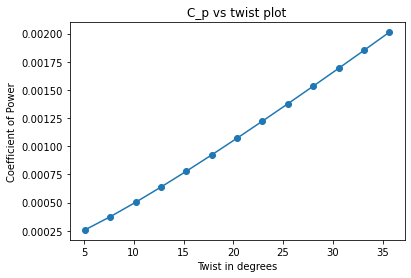

In [16]:
plt.plot((bemt4[0]*180/np.pi), bemt4[2], 'o-')


plt.xlabel("Twist in degrees")
plt.ylabel("Coefficient of Power")
plt.title("C_p vs twist plot");

# Rotor Design

### Option 1

In [17]:
omega=33 
ctcq=BEMT(no_of_blades=2, a=5.75, V=0, R=0.5-0.08, cutout=0.08, omega=omega, c_hub=0.10, taper_ratio=2, theta_tip=2*np.pi/180, twist=1, rho=0.02, )
print("Theta at 0.75R", ctcq[3]*180/np.pi)
print("Max Thrust", 2*ctcq[0]/2*0.02*np.pi*(0.5)**4*omega**2)
print("Power required",2*ctcq[1]/2*0.02*omega**4*np.pi*(0.5)**5)
print("Max weight", 2*ctcq[0]/2*0.02*np.pi*(0.5)**4/3.721*omega**2)
print("Twist angle", ctcq[2]*180/np.pi)

Theta at 0.75R 2.5114155251141557
Max Thrust 19.294702139059936
Power required 759.2012675258177
Max weight 5.185353974485337
Twist angle 10.5


### Option 2

In [18]:
omega=32
ctcq=BEMT(no_of_blades=3, a=5.75, V=0, R=0.5-0.1, cutout=0.1, omega=omega, c_hub=0.085, taper_ratio=1, theta_tip=1.7*np.pi/180, twist=1, rho=0.02, )
print("Theta at 0.75R", ctcq[3]*180/np.pi)
print("Max Thrust", 2*ctcq[0]/2*0.02*np.pi*(0.5)**4*omega**2)
print("Power required",2*ctcq[1]/2*0.02*omega**4*np.pi*(0.5)**5)
print("Max weight", 2*ctcq[0]/2*0.02*np.pi*(0.5)**4/3.721*omega**2)
print("Twist angle", ctcq[2]*180/np.pi)

Theta at 0.75R 2.1090225563909772
Max Thrust 18.96619483659343
Power required 486.245704564806
Max weight 5.097069292285254
Twist angle 6.799999999999999


### Option 3

In [19]:
omega=34.5
ctcq=BEMT(no_of_blades=4, a=5.75, V=0, R=0.5-0.1, cutout=0.1, omega=omega, c_hub=0.07, taper_ratio=0.8, theta_tip=1.2*np.pi/180, twist=1, rho=0.02, )
print("Theta at 0.75R", ctcq[3]*180/np.pi)
print("Max Thrust", 2*ctcq[0]/2*0.02*np.pi*(0.5)**4*omega**2)
print("Power required",2*ctcq[1]/2*0.02*omega**4*np.pi*(0.5)**5)
print("Max weight", 2*ctcq[0]/2*0.02*np.pi*(0.5)**4/3.721*omega**2)
print("Twist angle", ctcq[2]*180/np.pi)

Theta at 0.75R 1.4887218045112778
Max Thrust 18.89928823409622
Power required 649.4650139180318
Max weight 5.079088480004359
Twist angle 4.799999999999999


# Rotor Performance

In [20]:
#Code for plotting Thrust and Power against Theta 0.75R

omega=32

angles=[]
thrusts=[]
powers=[]

for i in range(20):
    ctcq=BEMT(no_of_blades=3, a=5.75, V=0, R=0.5-0.1, cutout=0.1, omega=omega, c_hub=0.085, taper_ratio=1, theta_tip=i*np.pi/180, twist=1, rho=0.02, )
    angles.append(ctcq[3]*180/np.pi)
    thrusts.append(2*ctcq[0]/2*0.02*np.pi*omega**2*(0.5)**4)
    powers.append(2*ctcq[1]/2*0.02*np.pi*omega**4*(0.5)**5)

#ignore error

C:\Users\ASUS\AppData\Local\Temp\ipykernel_17212\2950227708.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  f=no_of_blades/2/Lambda*(1-r/R)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_17212\2950227708.py:15: RuntimeWarning: invalid value encountered in double_scalars
  f=no_of_blades/2/Lambda*(1-r/R)


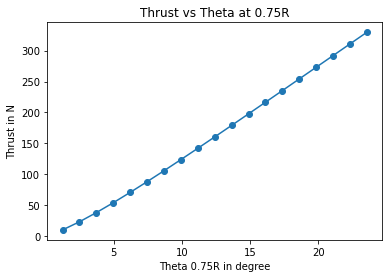

In [21]:
plt.plot(angles, thrusts, 'o-')
plt.title("Thrust vs Theta at 0.75R")
plt.xlabel("Theta 0.75R in degree")
plt.ylabel("Thrust in N");

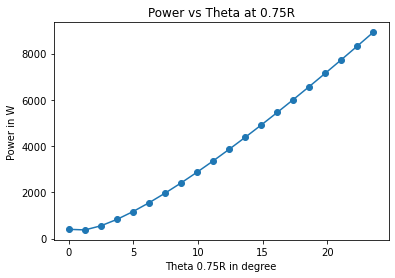

In [22]:
plt.plot(angles, powers, 'o-')
plt.title("Power vs Theta at 0.75R")
plt.xlabel("Theta 0.75R in degree")
plt.ylabel("Power in W");

### Finding stall thrust

In [23]:
print("Stall angle=", 2+ BEMT(no_of_blades=3, a=5.75, V=0, R=0.5-0.1, cutout=0.1, omega=omega, c_hub=0.085, taper_ratio=1, theta_tip=2*np.pi/180, twist=1, rho=0.02, )[2]*180/np.pi ,"degree" )
omega=32
ctcq=BEMT(no_of_blades=3, a=5.75, V=0, R=0.5-0.1, cutout=0.1, omega=omega, c_hub=0.085, taper_ratio=1, theta_tip=2*np.pi/180, twist=1, rho=0.02, )
print("Max Thrust at stall angle at 32 rad/s", 2*ctcq[0]/2*0.02*np.pi*(0.5)**4*omega**2, "N")

Stall angle= 10.0 degree
Max Thrust at stall angle at 32 rad/s 23.13321701108426 N
